In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from tqdm import tqdm
import descartes
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
sd_rl_map = gpd.read_file("CASanDiego1938.geojson")
sd_rl_map.loc[sd_rl_map.holc_id == None]

,name,holc_id,holc_grade,area_description_data,geometry


In [32]:
cenpops = gpd.read_file("data/nhgis0003_shape/US_tract_cenpop_2010.shp")
cenpops

,GISJOIN,GEOID,STATEFP,COUNTYFP,TRACTCE,POPULATION,LATITUDE,LONGITUDE,geometry
0,G0100010020100,01001020100,01,001,020100,1912,32.475973,-86.486772,POINT (887851.814 -517474.726)
1,G0100010020200,01001020200,01,001,020200,2170,32.471763,-86.472782,POINT (889200.085 -517811.023)
2,G0100010020300,01001020300,01,001,020300,3373,32.474011,-86.459639,POINT (890397.512 -517438.554)
3,G0100010020400,01001020400,01,001,020400,4386,32.468685,-86.443021,POINT (892002.859 -517873.612)
4,G0100010020500,01001020500,01,001,020500,10766,32.465330,-86.423696,POINT (893838.094 -518064.250)
...,...,...,...,...,...,...,...,...,...
73997,G7201530750501,72153750501,72,153,750501,4960,18.030947,-66.868030,POINT (3157557.538 -1653628.676)
73998,G7201530750502,72153750502,72,153,750502,2092,18.025411,-66.860207,POINT (3158556.581 -1653930.481)
73999,G7201530750503,72153750503,72,153,750503,2357,18.025744,-66.873776,POINT (3157121.454 -1654347.571)
74000,G7201530750601,72153750601,72,153,750601,5315,18.018029,-66.844223,POINT (3160471.741 -1654148.114)


,GISJOIN,GEOID,STATEFP,COUNTYFP,TRACTCE,POPULATION,LATITUDE,LONGITUDE,geometry
3560,G0600010400100,06001400100,06,001,400100,2937,37.859419,-122.230389,POINT (-2256988.423 353753.588)
3561,G0600010400200,06001400200,06,001,400200,1974,37.848292,-122.249525,POINT (-2258933.010 353008.380)
3562,G0600010400300,06001400300,06,001,400300,4865,37.840265,-122.254416,POINT (-2259588.545 352259.101)
3563,G0600010400400,06001400400,06,001,400400,3703,37.848451,-122.257310,POINT (-2259580.963 353210.600)
3564,G0600010400500,06001400500,06,001,400500,3517,37.848941,-122.264742,POINT (-2260189.175 353440.169)
...,...,...,...,...,...,...,...,...,...
11612,G0601150040800,06115040800,06,115,040800,4233,39.016818,-121.427571,POINT (-2155295.850 460082.489)
11613,G0601150040901,06115040901,06,115,040901,2783,39.134048,-121.423488,POINT (-2151484.803 472661.756)
11614,G0601150040902,06115040902,06,115,040902,1737,39.103993,-121.351583,POINT (-2146433.023 467786.712)
11615,G0601150041000,06115041000,06,115,041000,7357,39.272593,-121.428069,POINT (-2147757.789 487740.771)


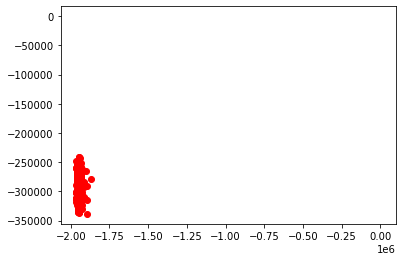

In [35]:
fig, ax = plt.subplots()
cali = cenpops[cenpops.STATEFP == '06']
# ax = sd_rl_map.geometry.plot()
for p in sd_rl_map.geometry:
    for geom in p:
        xs, ys = geom.exterior.xy    
        ax.plot(xs, ys, alpha=1, c='b')
for pt in cali[cali.COUNTYFP == '073'].geometry:
    ax.scatter(pt.x, pt.y, c='r')
cali